# Machine Learning Engineer Nanodegree
## Capstone Project - InstaCart Market Basket Analysis


### Model Development and Analysis 

In this final notebook, I show how I constructed the training set and the out-of-sample test set from the official training data. 

In [1]:
%%time
%run cap-utils.py

import warnings
warnings.filterwarnings('ignore')

# Import additional graphics libraries
import matplotlib.pyplot as plt
import seaborn as sb
sb.set(style="whitegrid", color_codes=True)

# Show matplotlib plots inline (nicely formatted in the notebook)
%matplotlib inline

import os

_datapath = './'
os.chdir(_datapath)

# RAW_STORE = 'instacart_raw.hdf5'
# HDF_STORE = 'instacart.hdf5'
# FVARS_STORE = 'features.hdf5'

Loaded numpy and pandas libraries
Wall time: 3.37 s


#### Import the functions we need from sklearn and other libraries

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import lightgbm as lgb

### Prepare the training and test datasets

Although Instacart provides separate train and test datasets, for this project, we are going to use a subset of their designated training set as our out-of-sample (oos) test set. This gives me a way to score our models and benchmarks consistently.

 1. Load the `orders` and `train` datasets. They are complementary in that the we can derive the users corresponding to each order in `train`.
 2. order numbers from the 1. Obtain the list of order_id that belong to the designated training set
 3. Take a 25% sample of these and set aside as the oos test set. This should be around 25000 orders, roughly the size of the set we have scores for from the competition submissions.

In [3]:
%%time
orders = get_from_hdf(['orders'], RAW_STORE)['orders']

ttrain = orders[orders.eval_set==1]
tr_orders, test_orders, x, x = train_test_split(ttrain.drop(['order_number'], axis=1), 
                                             ttrain[['order_number']], test_size=0.25, random_state=4)
del x
print "{} orders in our project training set".format(len(tr_orders))
print "{} orders in our o-o-s test set".format(len(test_orders))

Loading orders datasets ...
98406 orders in our project training set
32803 orders in our o-o-s test set
Wall time: 4.19 s


#### Build out the training and oos test sets
For each of the model train and test sets, we need to augment them with the features we created earlier. 
 1. Load the official training examples into a DataFrame - `ttrain`
 2. Add a column of ones to this Dataframe - this will be our label column `in_order`
 3. Load the extensive features dataset - `up_feat` (short for user-product features)
 4. Merge the train set for our model from the previous cell (`tr_orders`) with the features set (`up_feat`). This expands our `tr_orders` set to now include all products the user has ever purchased and it should be significanlty larger.
 5. This is now renamed `train`. 
 

In [4]:
%%time
t_train = get_from_hdf(['train'], RAW_STORE)['train']
t_train['in_order'] = (np.ones(len(t_train))).astype('int8')

up_feat = pd.read_hdf(FVARS_STORE, 'up_feat')
up_feat['up_in_last'] = up_feat['up_in_last'].astype('int8')

train=tr_orders.merge(up_feat, on='user_id')
print "The train set has {} order-product combinations".format(len(train))

Loading train datasets ...
The train set has 6353111 order-product combinations
Wall time: 30.1 s


#### Build out the training and oos test sets - continuation
 6. Merge `train` with `t_train` (the official training set, augmented with the label column) with a left join. The resulting table will have missing values for products that are in `train` not in the official order `t_train`.
 7. Fill the `in_order` (label column) with zeros to complete the labels.
 8. Load in the top-10 aisles table 
 9. Merge train with the top-10 aisles on `user_id`

In [5]:
%%time
train=train.merge(t_train[['order_id', 'product_id', 'in_order']], how='left', on=['order_id', 'product_id'])
train.in_order.fillna(0, inplace=True)

Wall time: 19.2 s


In [6]:
%%time
topN = pd.read_hdf(FVARS_STORE, "ua_top10")
train=train.merge(topN, on='user_id');

Wall time: 10.9 s


#### Change some of the column types to category

In [7]:
train['user_id'] = train['user_id'].astype('category')
train['aisle_id'] = train['aisle_id'].astype('category')
for i in range(1,11):
    train["top-"+str(i)] = train["top-{}".format(i)].astype('category')
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6353111 entries, 0 to 6353110
Data columns (total 34 columns):
order_id                  uint32
user_id                   category
eval_set                  int8
order_dow                 int8
order_hour_of_day         int8
days_since_prior_order    float64
aisle_id                  category
product_id                int64
up_cart_rank              float64
up_avg_days               float64
up_in_last                int8
up_times                  int64
up_reord_prob             float64
up_last_reord             int8
uo_count                  int16
ubasket_avg               float16
up_prob                   float64
up_dow                    float16
up_tod                    float16
up_30_avg                 float16
ua_ocount                 int16
u_a_reord                 float64
u_a_pcount                float64
in_order                  float64
top-1                     category
top-2                     category
top-3                  

### Build the oos test set using the same steps

In [9]:
%%time
oos_test=test_orders.merge(up_feat, on='user_id');
print "The train set has {} order-product combinations".format(len(train));

oos_test = oos_test.merge(t_train[['order_id', 'product_id', 'in_order']], how='left', on=['order_id', 'product_id']);
oos_test.in_order.fillna(0, inplace=True);

oos_test=oos_test.merge(topN, on='user_id');
print "The oos-test set has {} order-product combinations".format(len(oos_test));

oos_test['user_id'] = oos_test['user_id'].astype('category')
oos_test['aisle_id'] = oos_test['aisle_id'].astype('category')
for i in range(1,11):
    oos_test["top-"+str(i)] = oos_test["top-{}".format(i)].astype('category')

The train set has 6353111 order-product combinations
The oos-test set has 2121550 order-product combinations
Wall time: 35.1 s


### Creating the model training and validation sets
 - set up a variable with the list of features to ignore. This should contain `order_id`, `eval_set` and `product_id` at the very least
 - create the `data` set for model training and validation

In [10]:
%%time
features_ex = ['order_id', 'eval_set', 'product_id']
label_col = 'in_order'
data = train.drop(features_ex, axis=1);

Wall time: 2.84 s


##### Clear up some meory if needed
At this point, many of the structures we have used to build data are no longer needed. We can get rid of them
to clear up memory for the modelling

In [11]:
del t_train, orders, up_feat, topN
gc.collect() # releases about 1 GB

199

### Model Training
 
 - use `train_test_split` to create a training and validation sets
     - the define models, train, predict and score

In [15]:
%%time
# Remove user_id from features
X_train, X_val, y_train, y_val = train_test_split(data.drop([label_col]+['user_id'], axis=1),
                                                  data[label_col],
                                                  test_size=0.50, random_state=42)


Wall time: 43.9 s


In [39]:
# Helper function for printing out precision and accuracy 
def prec(cf):
    #cf = confusion matrix
    a=cf*1.0
    precision=a[1][1]/a[1].sum()
    recall = a[1][1]/(a[0][1]+a[1][1])
    return "Precision: {:.4f}, recall ={:.4f}, f1-score={:.4f}".format(precision, 
                                                                       recall,
                                                                       2*precision*recall/(precision+recall))

# Model validation report
def report(y_true, y_pred, threshold=0.2):
    print "\nModel Report"
    print "Accuracy : %.4g" % accuracy_score(y_true, y_pred>threshold)
    print "AUC Score (Train): %f" % roc_auc_score(y_true, y_pred)
    print "f1-score : %.4g" % f1_score(y_true, y_pred>threshold)
    print "Calculating confusion matrix .."
    cf = confusion_matrix(y_true, y_pred>threshold)
    print "\nThreshold={:.4f}, CF: {}".format(threshold, prec(cf))
    
# Model training and prediction
#  - params is the params dictionary to pass to the object
#  - X_train, y_train, X_valid, y_valid as the training and validation input features and labels 
#  - N - number of boosting rounds
#  - S - early stopping round (cost function must not get smaller for these many rounds before process stops )
#
# returns model and preicted labels for validation set
def fit_model(params, X_train, y_train, X_eval, y_eval, N=None, S=None, T=0.20):
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    print('Start training...')
    # train
    if 'n_estimators' in params:
        params['num_boost_round'] = params['n_estimators']
        params.pop('n_estimators', 1)
    if 'silent' in params:
        params['verbose'] = 5 if params['silent'] else 0
        params.pop('silent')
    params['early_stopping_rounds'] = max(S, 5)
    print params
    gbm = lgb.train(params,
                    lgb_train,
                    params['num_boost_round'],
                    lgb_eval)

    if (gbm.best_iteration==0):
        print "Fit may not have converged .. using model from final iteration"
        gbm.best_iteration = params['num+boost_round']-1
    print('Start predicting... with best iteration = {}'.format(gbm.best_iteration))
    y_pred = gbm.predict(X_val, num_iteration=gbm.best_iteration)   
    report(y_val, y_pred, T)
    return gbm, y_pred

In [75]:
# Plot features bar plot

def plot_importances(gbm, N=15):
    feat_imp=pd.DataFrame(np.array([gbm.feature_name(), gbm.feature_importance()]).transpose(), 
                      columns=['feature','importance'])
    feat_imp.importance = feat_imp.importance.astype('int')
    feat_imp.sort_values(by='importance', ascending=False, inplace=True)
    feat_imp.set_index('feature', inplace=True)
    feat_imp[:N].plot(kind='barh', title='Feature Importances')
    plt.ylabel('Feature Importance Score');
    plt.xlabel('Importance')

# Iterate through threshold values to find best one
def choose_threshold(y_true, y_pred, tstart, tend, t_initial):
    
    othresh=t_initial
    step = (tend-tstart)/5.0
    oscore=0
    for _ in range(5):
        thresh=tstart + _*step
        #thresh=0.22
        score = f1_score(y_true, y_pred>thresh)
        if score>oscore:
            oscore=score
            othresh=thresh
        print "Threshold={:.4f}, score={:.4f} - {}".format(thresh, score, \
                                                           prec(confusion_matrix(y_true, y_pred>thresh)))
    cf = confusion_matrix(y_true, y_pred>othresh)
    print "\nThreshold={:.4f}, score={:.4f} - {}".format(othresh, 
                                                       f1_score(y_true, y_pred>othresh), 
                                                       prec(cf))
    print cf
    return othresh

In [50]:
%%time
estimator = lgb.LGBMClassifier(boosting_type='rf',                               
                               #num_leaves=91,
                               #learning_rate: 0.1,
                               bagging_fraction= 0.9,
                               bagging_freq = 5,
                               #is_training_metric = True,
                               feature_fraction = 0.9,                               
                               metric=['binary_logloss', 'auc'],
                               early_stopping_rounds=10,
                               n_estimators= 30,
                               #max_depth=7,
                              )
p=estimator.get_params()
p['silent']=False
g, f= fit_model(p, X_train, y_train, X_val, y_val, S=10)

Start training...
{'num_leaves': 31, 'reg_alpha': 0, 'subsample_for_bin': 50000, 'verbose': 0, 'learning_rate': 0.1, 'subsample_freq': 1, 'early_stopping_rounds': 10, 'num_boost_round': 30, 'bagging_fraction': 0.9, 'metric': ['binary_logloss', 'auc'], 'boosting_type': 'rf', 'colsample_bytree': 1, 'bagging_freq': 5, 'min_child_samples': 10, 'nthread': -1, 'min_child_weight': 5, 'min_split_gain': 0, 'subsample': 1, 'reg_lambda': 0, 'seed': 0, 'max_bin': 255, 'objective': 'binary', 'max_depth': -1, 'feature_fraction': 0.9}
[1]	valid_0's binary_logloss: 0.304534	valid_0's auc: 0.793284
[2]	valid_0's binary_logloss: 0.304534	valid_0's auc: 0.793284
[3]	valid_0's binary_logloss: 0.304534	valid_0's auc: 0.793284
[4]	valid_0's binary_logloss: 0.304534	valid_0's auc: 0.793284
[5]	valid_0's binary_logloss: 0.304534	valid_0's auc: 0.793284
[6]	valid_0's binary_logloss: 0.304515	valid_0's auc: 0.795147
[7]	valid_0's binary_logloss: 0.304478	valid_0's auc: 0.795686
[8]	valid_0's binary_logloss: 0.3

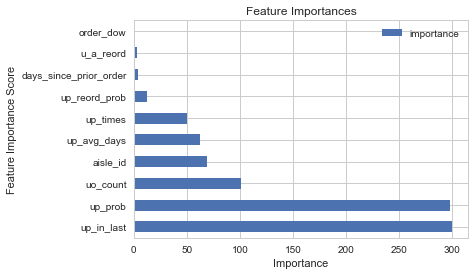

In [56]:
plot_importances(g, 10)

Start training...
{'num_leaves': 31, 'reg_alpha': 0, 'subsample_for_bin': 50000, 'verbose': 0, 'learning_rate': 0.1, 'subsample_freq': 1, 'early_stopping_rounds': 10, 'num_boost_round': 30, 'bagging_fraction': 0.9, 'metric': ['binary_logloss', 'auc'], 'boosting_type': 'gbdt', 'colsample_bytree': 1, 'bagging_freq': 5, 'min_child_samples': 10, 'nthread': -1, 'min_child_weight': 5, 'min_split_gain': 0, 'subsample': 1, 'reg_lambda': 0, 'seed': 0, 'max_bin': 255, 'objective': 'binary', 'max_depth': -1, 'feature_fraction': 0.9}
[1]	valid_0's binary_logloss: 0.626558	valid_0's auc: 0.793284
[2]	valid_0's binary_logloss: 0.572137	valid_0's auc: 0.79825
[3]	valid_0's binary_logloss: 0.526981	valid_0's auc: 0.801524
[4]	valid_0's binary_logloss: 0.489132	valid_0's auc: 0.802067
[5]	valid_0's binary_logloss: 0.45715	valid_0's auc: 0.803324
[6]	valid_0's binary_logloss: 0.429947	valid_0's auc: 0.803732
[7]	valid_0's binary_logloss: 0.406679	valid_0's auc: 0.80403
[8]	valid_0's binary_logloss: 0.38

In [62]:
%%time
p=estimator.get_params()
p['boosting_type'] = 'dart'
p['silent']=False
g, f= fit_model(p, X_train, y_train, X_val, y_val, S=10)

Start training...
{'num_leaves': 31, 'reg_alpha': 0, 'subsample_for_bin': 50000, 'verbose': 0, 'learning_rate': 0.1, 'subsample_freq': 1, 'early_stopping_rounds': 10, 'num_boost_round': 30, 'bagging_freq': 5, 'metric': ['binary_logloss', 'auc'], 'boosting_type': 'dart', 'colsample_bytree': 1, 'bagging_fraction': 0.9, 'min_child_samples': 10, 'nthread': -1, 'min_child_weight': 5, 'min_split_gain': 0, 'subsample': 1, 'reg_lambda': 0, 'seed': 0, 'max_bin': 255, 'objective': 'binary', 'max_depth': -1, 'feature_fraction': 0.9}
[1]	valid_0's binary_logloss: 0.626558	valid_0's auc: 0.793284
[2]	valid_0's binary_logloss: 0.572137	valid_0's auc: 0.79825
[3]	valid_0's binary_logloss: 0.526981	valid_0's auc: 0.801524
[4]	valid_0's binary_logloss: 0.489132	valid_0's auc: 0.802067
[5]	valid_0's binary_logloss: 0.45715	valid_0's auc: 0.803324
[6]	valid_0's binary_logloss: 0.460703	valid_0's auc: 0.803566
[7]	valid_0's binary_logloss: 0.432966	valid_0's auc: 0.803871
[8]	valid_0's binary_logloss: 0.4

In [79]:
r""" '_prod_tot_cnts', '_prod_reorder_times', '_up_first_order_number','_user_total_products'
"""
choose_threshold(y_val, y_pred, 0.18, 0.22, 0.18)

Threshold=0.1800, score=0.4207 - Precision: 0.5429, recall =0.3434, f1-score=0.4207
Threshold=0.1880, score=0.4224 - Precision: 0.5273, recall =0.3524, f1-score=0.4224
Threshold=0.1960, score=0.4239 - Precision: 0.5127, recall =0.3613, f1-score=0.4239
Threshold=0.2040, score=0.4241 - Precision: 0.4976, recall =0.3696, f1-score=0.4241
Threshold=0.2120, score=0.4241 - Precision: 0.4832, recall =0.3779, f1-score=0.4241

Threshold=0.2040, score=0.4241 - Precision: 0.4976, recall =0.3696, f1-score=0.4241
[[2603321  263189]
 [ 155758  154288]]


0.20400000000000001

In [63]:
%%time
estimator = lgb.LGBMClassifier(boosting_type='gbdt',                               
                               bagging_fraction= 0.9,
                               bagging_freq = 5,
                               feature_fraction = 0.9,                               
                               metric=['binary_logloss', 'auc'],
                               early_stopping_rounds=10,
                               n_estimators= 30,
                               silent=False,
                              )
param_grid = {
    'learning_rate': [0.05, 0.075,  0.15],
    'num_leaves': [51, 81, 121]
}

gbm = GridSearchCV(estimator, param_grid)

gbm.fit(X_train, y_train )


print('Best parameters found by grid search are:', gbm.best_params_)
print('Best score:', gbm.best_score_)

('Best parameters found by grid search are:', {'num_leaves': 121, 'learning_rate': 0.15})
('Best score:', 0.90778941337392238)
Wall time: 56min 52s


In [ ]:

%%time
p=gbm.best_estimator_.get_params()
p['min_child_samples'] = 50
p['silent']=False
p['learning_rate']=0.18
p['n_estimators']=200
g, f= fit_model(p, X_train, y_train, X_val, y_val, S=10)


Model Report
Accuracy : 0.8661
AUC Score (Train): 0.821731
f1-score : 0.424
Calculating confusion matrix ..

Threshold=0.2000, CF: Precision: 0.5051, recall =0.3654, f1-score=0.4240
Wall time: 15min 27s


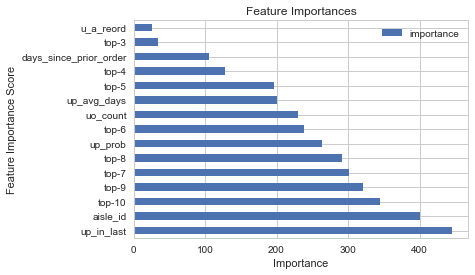

In [71]:
%%time
best=gbm.best_estimator_
param_grid = { 'learning_rate': [0.18] } # This is just to fake out GridSearchCV and do a 5-fold cv

gbmCV = GridSearchCV(best, param_grid, cv=5)
gbmCV.fit(X_train, y_train )
gcv=gbm.best_estimator_.booster_
y_pred=gcv.predict(X_val)
report(y_val, y_pred);
plot_importances(gcv)

### Score final model against test (OOS) set

In [78]:
%%time
features_ex = ['order_id', 'eval_set', 'product_id']
label_col = 'in_order'
test = oos_test.drop(features_ex, axis=1)
y_test = test['in_order']
X_test = test.drop(['user_id', 'in_order'], axis=1)
yt_pred = gcv.predict(X_test)
report(y_test, yt_pred)


Model Report
Accuracy : 0.8634
AUC Score (Train): 0.818258
f1-score : 0.4167
Calculating confusion matrix ..

Threshold=0.2000, CF: Precision: 0.4972, recall =0.3587, f1-score=0.4167
Wall time: 1min 4s


### Different training set - use different random seed


Model Report
Accuracy : 0.8686
AUC Score (Train): 0.827593
f1-score : 0.4347
Calculating confusion matrix ..

Threshold=0.2000, CF: Precision: 0.5186, recall =0.3742, f1-score=0.4347


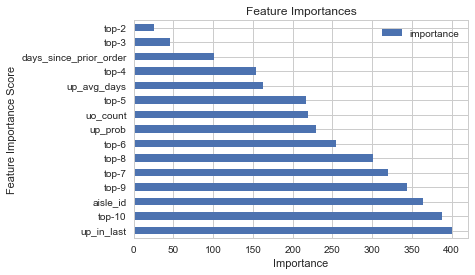

In [80]:
X_train, X_val, y_train, y_val = train_test_split(data.drop([label_col]+['user_id'], axis=1),
                                                  data[label_col],
                                                  test_size=0.50, random_state=22)
param_grid = { 'learning_rate': [0.18] } # This is just to fake out GridSearchCV and do a 5-fold cv

gbmCV2 = GridSearchCV(best, param_grid, cv=5)
gbmCV2.fit(X_train, y_train )
gcv2=gbmCV2.best_estimator_.booster_
y2_pred=gcv.predict(X_val)
report(y_val, y2_pred);
plot_importances(gcv2)

### Different training set - different test/train split and different seed


Model Report
Accuracy : 0.8685
AUC Score (Train): 0.827619
f1-score : 0.4351
Calculating confusion matrix ..

Threshold=0.2000, CF: Precision: 0.5180, recall =0.3750, f1-score=0.4351


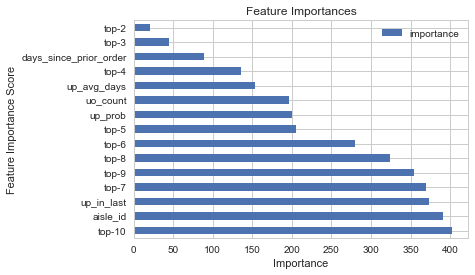

In [82]:
X_train, X_val, y_train, y_val = train_test_split(data.drop([label_col]+['user_id'], axis=1),
                                                  data[label_col],
                                                  test_size=0.60, random_state=30)
param_grid = { 'learning_rate': [0.18] } # This is just to fake out GridSearchCV and do a 5-fold cv

gbmCV3 = GridSearchCV(best, param_grid, cv=5)
gbmCV3.fit(X_train, y_train )
gcv3=gbmCV3.best_estimator_.booster_
y3_pred=gcv.predict(X_val)
report(y_val, y3_pred);
plot_importances(gcv3)

### OOS Test score for retrained models

In [83]:
yt2_pred = gcv2.predict(X_test)
report(y_test, yt2_pred)


Model Report
Accuracy : 0.8635
AUC Score (Train): 0.818804
f1-score : 0.4175
Calculating confusion matrix ..

Threshold=0.2000, CF: Precision: 0.4982, recall =0.3593, f1-score=0.4175


In [84]:
yt3_pred = gcv3.predict(X_test)
report(y_test, yt3_pred)


Model Report
Accuracy : 0.8635
AUC Score (Train): 0.818346
f1-score : 0.4164
Calculating confusion matrix ..

Threshold=0.2000, CF: Precision: 0.4959, recall =0.3589, f1-score=0.4164


### Score benchmarks against test (OOS) set

In [ ]:
%%time
d = get_from_hdf(['orders', 'priors'])
XX=oos_test.drop('in_order', axis=1)

In [ ]:
%%time
B1 = bench1_fit(d['priors'], d['orders'])
B1_pred = bench_predict(B1, XX)
report(oos_test.in_order, B1_pred)

In [ ]:
%%time
B2 = bench2_fit(d['priors'], d['orders'])
B2_pred = bench_predict(B2, XX)
report(oos_test.in_order, B2_pred)

In [ ]:
%%time
B3 = bench3_fit(d['priors'], d['orders'])
B3_pred = bench_predict(B3, XX)
report(oos_test.in_order, B3_pred)